In [1]:
import os 
import cv2 
from PIL import Image
import json 
import numpy as np

import hydra 
from omegaconf import DictConfig, OmegaConf

with hydra.initialize(version_base='1.2', config_path='config'):
    cfg = hydra.compose(config_name='default_data')
    print(OmegaConf.to_yaml(cfg))


data_folder:
- data/SORDI_2022_Industrial_Rooms/SORDI_2022_h4022_industrial rooms 360p
- data/SORDI_2022_Industrial_Rooms/SORDI_2022_h4023_industrial rooms
- data/SORDI_2022_Regensburg_plant/SORDI_2022_h4024_regensburg plant 360p
- data/SORDI_2022_Regensburg_plant/SORDI_2022_h4025_regensburg plant
eval_folder:
- data/eval



/home/phidch/miniconda3/envs/py36/lib/python3.6/site-packages/hydra/_internal/config_loader_impl.py:216: UserWarning: provider=hydra.searchpath in main, path=config is not available.
  message=f"provider={source.provider}, path={source.path} is not available.",


(360, 640, 3)


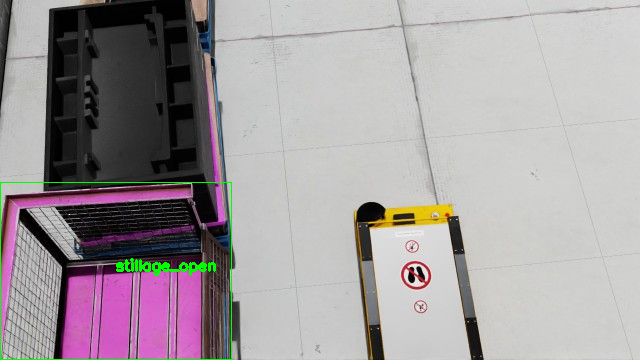

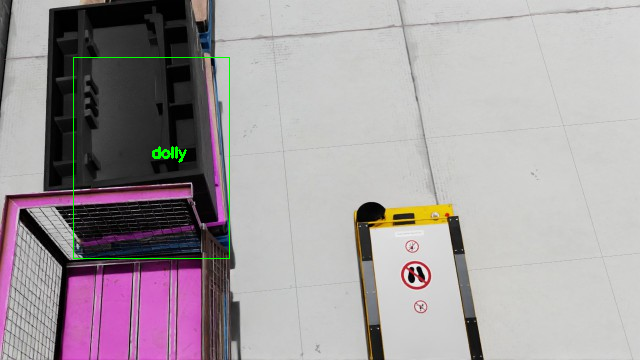

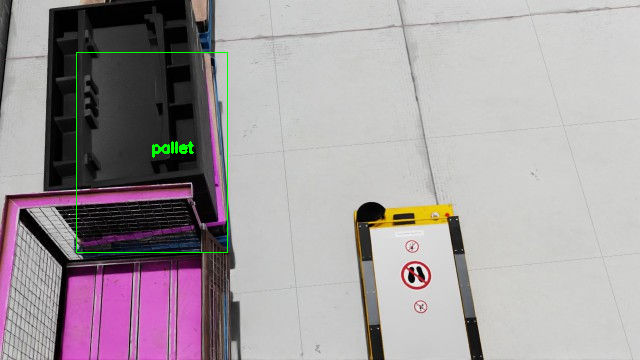

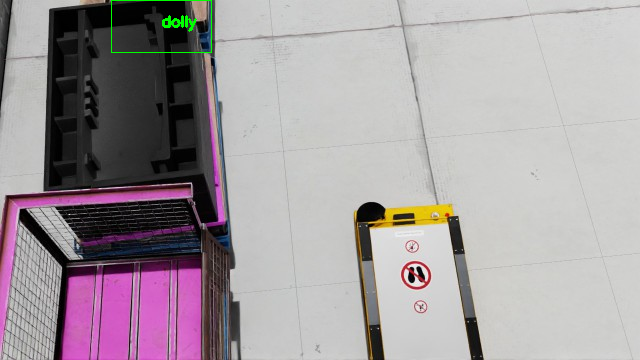

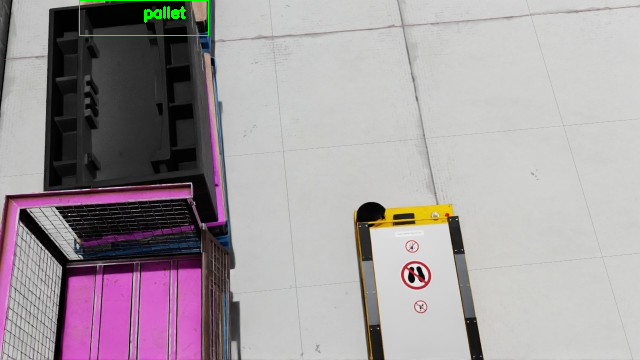

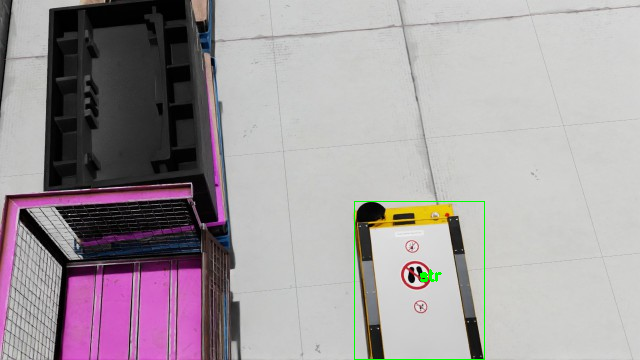

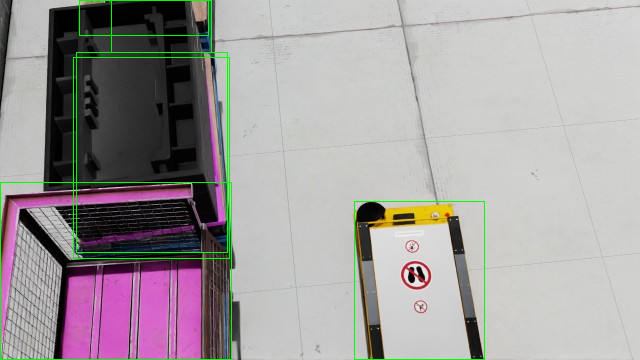

In [36]:
def viz_image(folder:str, img_id:int):
    img = cv2.imread(f'{folder}/images/{img_id}.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)
    with open(f'{folder}/labels/json/{img_id}.json', 'r') as f:
        labels = json.load(f)
    
    img1 = img.copy()
    for label in labels:
        label = OmegaConf.create(label)
        # color = list(np.random.random(size=3) * 256)
        color = (0,255,0)
        p1 = (label.Left, label.Top)
        p2 = (label.Right, label.Bottom)
        pText = (int((p1[0]+p2[0])/2), int((p1[1]+p2[1])/2))
        h = label.Bottom - label.Top
        w = label.Right - label.Left
        if h>10 and w>10:
            ## for single display
            img0 = img.copy()
            cv2.rectangle(img0,p1,p2,color,1)
            cv2.putText(img0, label['ObjectClassName'], org=pText, color=color, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, thickness=2)
            display(Image.fromarray(img0))

            cv2.rectangle(img1,p1,p2,color,1)
    
    display(Image.fromarray(img1))
    
viz_image(cfg.data_folder[0], 100)

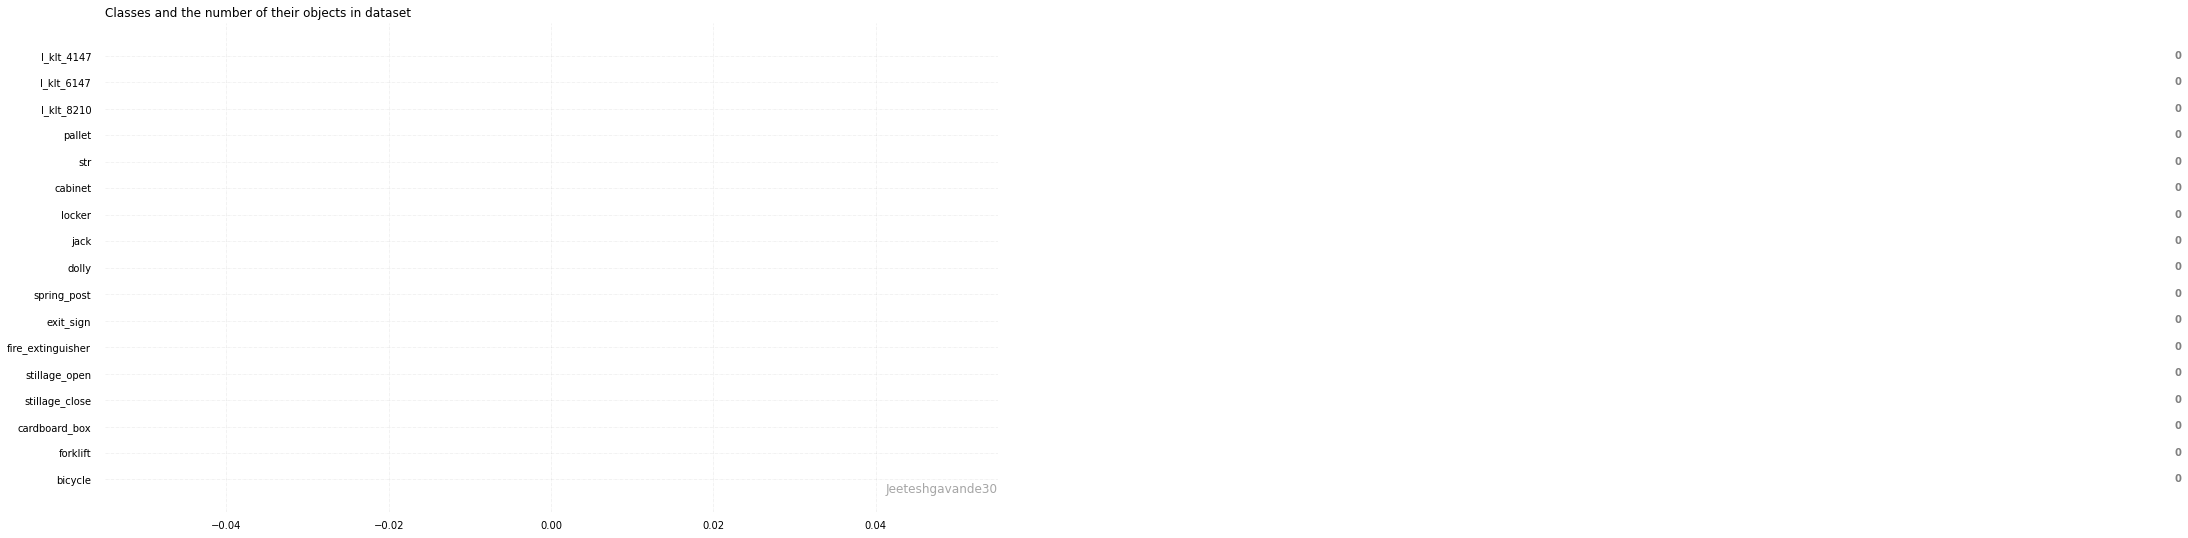

In [21]:
stat = {}
with open(f'{cfg.eval_folder[0]}/objectclasses.json', 'r') as f:
    meta_data = json.load(f)
    for meta in meta_data:
        stat[meta['Name']] = 0
stat

from matplotlib import pyplot as plt 
def plot_bar(stat):
    name = list(stat.keys())
    price = list(stat.values())
    # Figure Size
    fig, ax = plt.subplots(figsize =(16, 9))
    
    # Horizontal Bar Plot
    ax.barh(name, price)
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    
    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
    
    # Show top values
    ax.invert_yaxis()
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5,
                str(round((i.get_width()), 2)),
                fontsize = 10, fontweight ='bold',
                color ='grey')
    
    # Add Plot Title
    ax.set_title('Classes and the number of their objects in dataset',
                loc ='left', )
    
    # Add Text watermark
    fig.text(0.9, 0.15, 'phidch', fontsize = 12,
            color ='grey', ha ='right', va ='bottom',
            alpha = 0.7)
    
    # Show Plot
    plt.show()

plot_bar(stat)

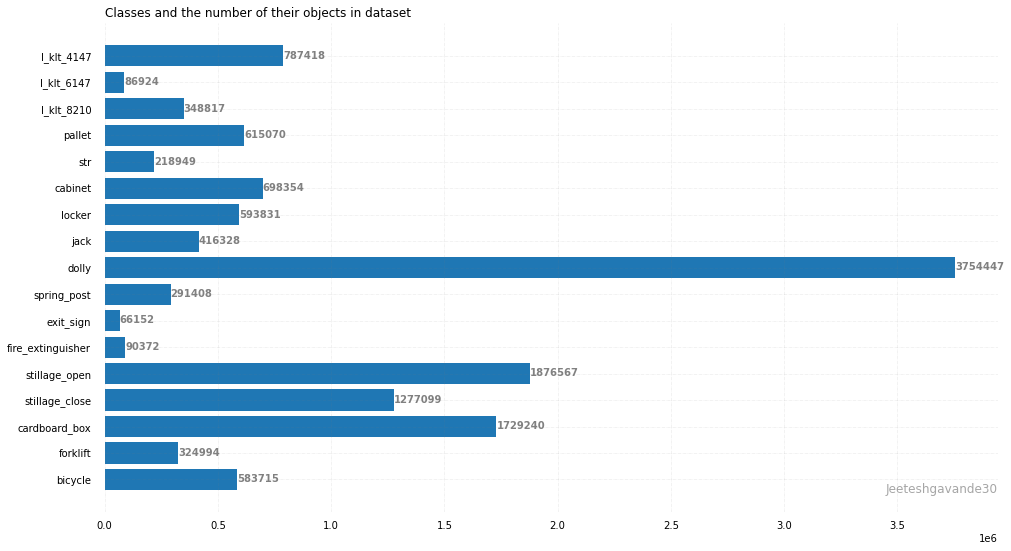

In [23]:
with open(f'data/config.json', 'r') as f:
    datasets = json.load(f)

stat_no_check_with_single_assets = stat.copy()
for dataset in datasets:
    objs = dataset['object_classes']
    for obj in objs.keys():
        stat_no_check_with_single_assets[obj] += objs[obj]

plot_bar(stat_no_check_with_single_assets)

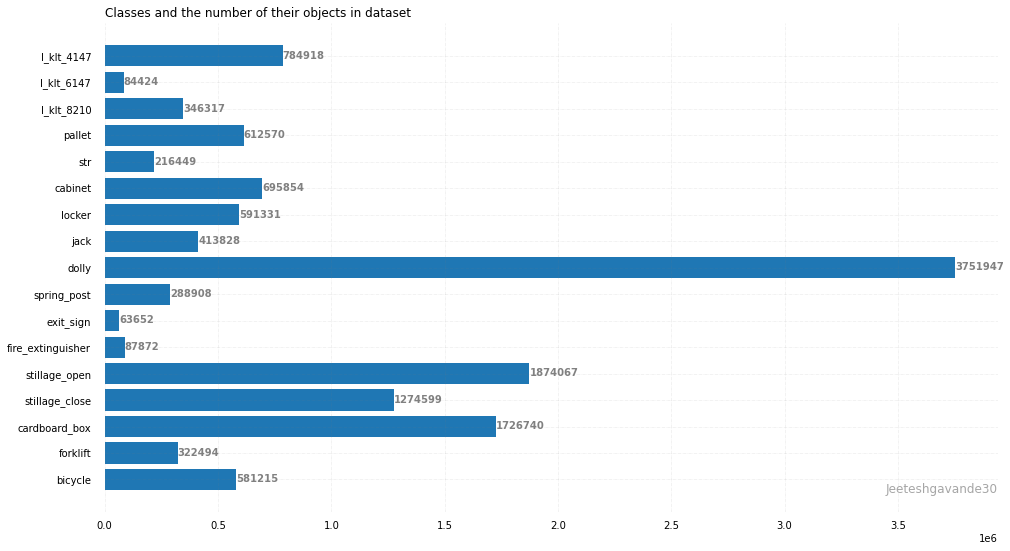

In [24]:
with open(f'data/config.json', 'r') as f:
    datasets = json.load(f)

stat_no_check_without_single_assets = stat.copy()
for dataset in datasets[17:]:
    objs = dataset['object_classes']
    for obj in objs.keys():
        stat_no_check_without_single_assets[obj] += objs[obj]

plot_bar(stat_no_check_without_single_assets)

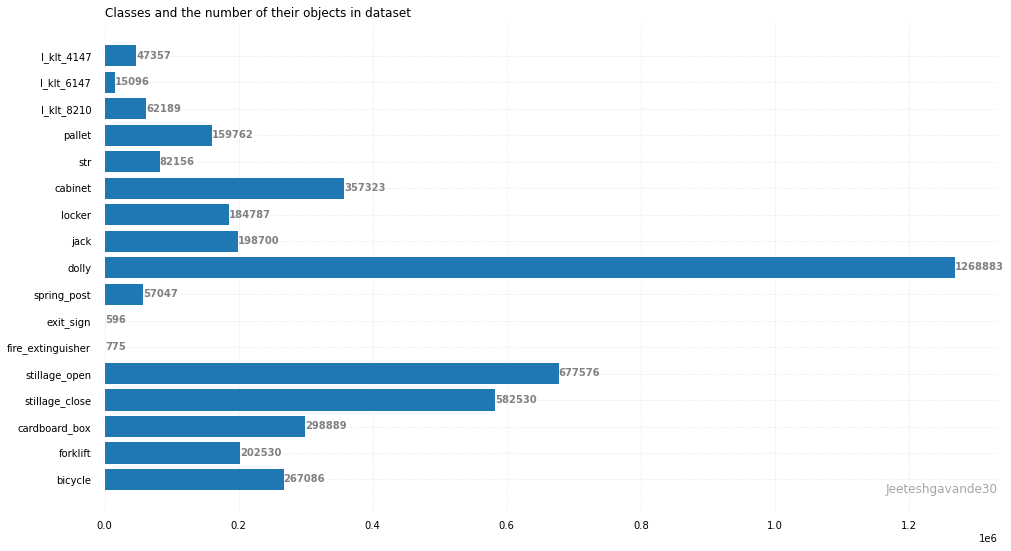

In [25]:
def check_object(gt:dict):
    label = OmegaConf.create(gt)
    h = label.Bottom - label.Top
    w = label.Right - label.Left
    if h>10 and w>10:
        return True
    return False

stat_with_check = stat.copy()
for fol in cfg.data_folder:
    label_fol = os.path.join(fol, 'labels', 'json')
    for gt_file in os.listdir(label_fol):
        with open(os.path.join(label_fol, gt_file), 'r') as f:
            gts = json.load(f)
            for gt in gts:
                if check_object(gt):
                    stat_with_check[gt['ObjectClassName']] += 1


plot_bar(stat_with_check)